In [245]:
import numpy as np
import pandas as pd
import cv2
import os
from steering.util import full_path
import matplotlib.pyplot as plt
from scipy import misc

In [295]:
data_folder = full_path("image_data")
video_folders = [os.path.join(data_folder,child) for child in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder,child))]

In [388]:
def video_dataframe(video_folder):
  df = pd.read_csv(video_folder + "/interpolated.csv")
  center_df = setup_df(video_folder, 0., df[df.frame_id == 'center_camera'])
  return center_df
#   left_df = setup_df(video_folder, -0.05, df[df.frame_id == 'left_camera'])
#   right_df = setup_df(video_folder, 0.05, df[df.frame_id == 'right_camera'])
  return pd.concat([center_df, left_df, right_df], ignore_index=True)

def setup_df(video_folder, adjustment, df):
  df = df.filter(items = ['filename', 'angle','speed'])
  df.angle = adjustment + df.angle
  df.filename = video_folder + "/" + df.filename
  df = df.iloc[::3]
  df = df.reset_index(drop=True)
  return df

dfs = [video_dataframe(video_folder) for video_folder in video_folders]
video_data = pd.concat(dfs, ignore_index=True).reset_index(drop=True)

print(len(video_data))

11271


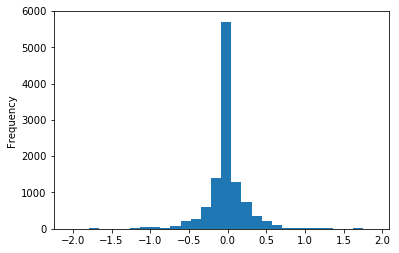

In [389]:
video_data['angle'].plot.hist(bins=30)
plt.show()

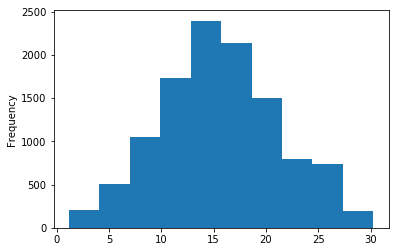

In [390]:
video_data['speed'].plot.hist()
plt.show()

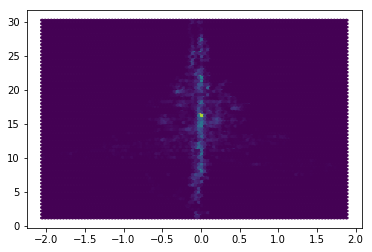

In [392]:
plt.hexbin(video_data['angle'].values,video_data['speed'].values)
plt.show()

In [440]:
max_vals = len(video_data[(np.abs(video_data.angle) >= 0.4)])
mid_vals = len(video_data[(np.abs(video_data.angle) >= 0.1) & (np.abs(video_data.angle) < 0.4)])
min_vals = len(video_data[(np.abs(video_data.angle) < 0.1)])
print(len(video_data), max_vals, mid_vals, min_vals)

11271 1188 3246 6837


In [395]:
def display_k(images, results):
  assert(len(images) == len(results))
  f, axes = plt.subplots(int(len(images)), 1, figsize=(5, 15))
  f.tight_layout()
  axes = np.reshape(axes, -1)
  
  for i in range(len(axes)):
    r = results[i]
    title_unformatted = "Speed: {0:.4f}" \
    "\nAngle: {1:.2f}"
    title = title_unformatted.format(r[1], r[0])

    axes[i].imshow(images[i])
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')
  plt.subplots_adjust(top=0.85)
  plt.show()

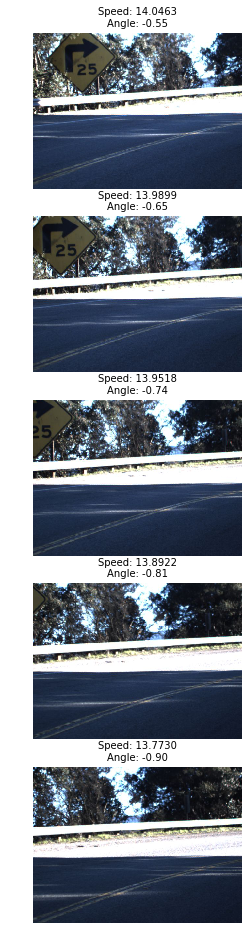

In [396]:
last_idx = video_data[video_data.angle < -0.9].index[0]
frames = video_data.iloc[last_idx-4:last_idx+1]
features = frames.filter(items = ['angle','speed']).values
image_files = [misc.imread(f) for f in frames['filename'].values]

display_k(image_files, features)

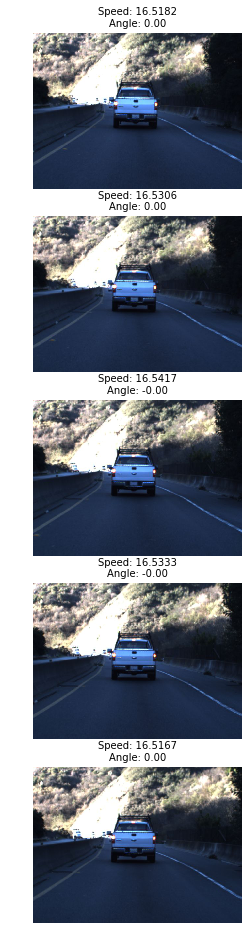

In [397]:
last_idx = video_data[video_data.angle == 0.].index[10]
frames = video_data.iloc[last_idx-4:last_idx+1]
features = frames.filter(items = ['angle','speed']).values
image_files = [misc.imread(f) for f in frames['filename'].values]

display_k(image_files, features)

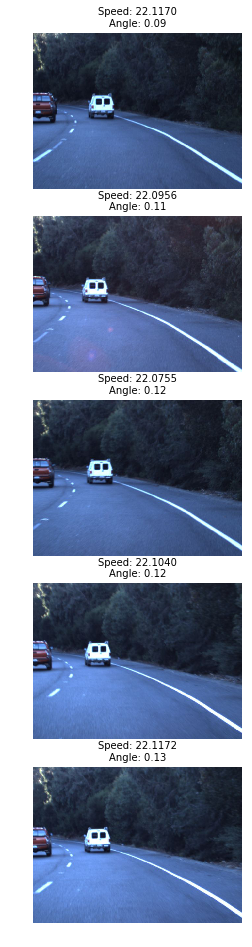

In [419]:
last_idx = video_data[(video_data.angle < 0.13) & (video_data.angle > 0.1)].index[10]
frames = video_data.iloc[last_idx-4:last_idx+1]
features = frames.filter(items = ['angle','speed']).values
image_files = [misc.imread(f) for f in frames['filename'].values]

display_k(image_files, features)

In [441]:
last_frame_df = video_data[4::5]
high_last_frame_idx = last_frame_df[(np.abs(last_frame_df.angle) >= 0.4)].index
mid_last_frame_idx = last_frame_df[(np.abs(last_frame_df.angle) < 0.5) & (np.abs(last_frame_df.angle) >= 0.1)].index
low_last_frame_idx = last_frame_df[(np.abs(last_frame_df.angle) < 0.1)].index

In [442]:
def collect_frames(idxs):
  all_idxs = []
  for idx in idxs:
    for i in range(-4, 1):
      all_idxs.append(idx + i)
  return all_idxs

high_angle_frames = video_data.iloc[collect_frames(high_last_frame_idx)]
mid_angle_frames = video_data.iloc[collect_frames(mid_last_frame_idx)]
low_angle_frames = video_data.iloc[collect_frames(low_last_frame_idx)]

In [447]:
print(len(high_angle_frames), len(mid_angle_frames), len(low_angle_frames))

1185 3685 6870


Because the low angle frames are the most common, I am going to over sample the high angle frames by 3 and flip them (x6). I am going to flip the mid angle frames (x2). This should give the training set about an even distribution of frames by angle. Speed is normally distributed and I won't spend any effort redistributing it. 

I played with the idea of using the left and right frames with adjusted steering angles to add more frames with larger steering angles. But after looking at left and right frames (work not shown) it seems like the appropriate steering angle difference for the left right and center frames is not very large. My initial estimate is +/- 0.05. Because this would not significantly add more large steering wheel angles and because I am not very confident in my estimation, I am going to leave the left and right images out of the dataset. 